# Imports

### Libraries

In [1]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
import json
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as dates_
import seaborn as sns
from pyowm.owm import OWM
from pyowm.utils import timestamps, formatting
from datetime import datetime, timedelta, timezone, date

### Data

##### Heart Beat Data

In [2]:
# Find all json files
samsung_base_dir = os.path.join('data', 'Samsung Data', '28.11.2021')

json_file_names = []
for file in os.listdir(os.path.join(samsung_base_dir, 'jsons', 'com.samsung.health.heart_rate')):
    if file != '.ipynb_checkpoints':
        json_file_names.append(file)

df_json_readings = []
for i in range(len(json_file_names)):
    file_name = json_file_names[i]
    df = pd.read_json(os.path.join(samsung_base_dir,'jsons', 'com.samsung.health.heart_rate', file_name))
    df_json_readings.append(df.copy())

df_heart_rate_json = pd.concat(df_json_readings, axis=0, ignore_index=True)
df_heart_rate_json = df_heart_rate_json.sort_values(by=['start_time'], ascending=True, ignore_index=True)

In [3]:
df_heart_rate_json.head()

,heart_rate,heart_rate_max,heart_rate_min,start_time,end_time
0,80,82,79,2021-11-28 12:40:00,2021-11-28 12:40:59
1,83,87,78,2021-11-28 12:41:00,2021-11-28 12:41:59
2,82,85,80,2021-11-28 12:42:00,2021-11-28 12:42:59
3,83,86,80,2021-11-28 12:43:00,2021-11-28 12:43:59
4,80,82,77,2021-11-28 12:44:00,2021-11-28 12:44:59


##### Calendar Data

In [4]:
# Load CSV file
cal_base_dir = os.path.join('data', 'Calendar Data')
df_calendar = pd.read_csv(os.path.join('data', 'Calendar Data', '22.11.2021.csv'), sep='\t')

# Rename columns with simpler names
df_calendar = df_calendar.rename(columns={'Given planned earliest start' : 'start_time', 'Given planned earliest end' : 'end_time'})
df_calendar = df_calendar.drop(['Notes', 'Assigned Resources', 'Additional Title'], axis=1)

# Convert date columns into date format
df_calendar['start_time'] = pd.to_datetime(df_calendar['start_time'], dayfirst=True)
df_calendar['end_time'] = pd.to_datetime(df_calendar['end_time'], dayfirst=True)

# Sort Dataframe by date
df_calendar = df_calendar.sort_values(by=['start_time'], ascending=True, ignore_index=True)

In [5]:
df_calendar.head()

,Title,start_time,end_time
0,Physio,2020-07-01 15:30:00,2020-07-01 16:30:00
1,Rdv edm pour les sats,2020-07-01 18:00:00,2020-07-01 19:00:00
2,Rdv Jessie sortie,2020-07-01 21:00:00,2020-07-01 22:00:00
3,Physio,2020-07-06 13:30:00,2020-07-06 14:30:00
4,Anni Clem Co,2020-07-07 12:00:00,2020-07-07 13:00:00


##### Weather Data
We can go back up to 5 days ago, but unfortunately not more than that.

In [6]:
APIKEY = '12c406b33039d61c116a70eefb3526bb' #your API Key here as string
OpenWMap = OWM(APIKEY) # Use API key to get data
mgr = OpenWMap.weather_manager()
lausanne_lat = 46.5196535
lausanne_lon = 6.6322734

# Query current data
observation_cur = mgr.weather_at_place('Lausanne') # give where you need to see the weather
weather_cur = observation_cur.weather

# Query yesterday data
yesterday_epoch = formatting.to_UNIXtime(timestamps.yesterday())
one_call_yesterday = mgr.one_call_history(lat=lausanne_lat, lon=lausanne_lon, dt=yesterday_epoch)
weather_yesterday = one_call_yesterday.forecast_hourly

# Query 4 days ago data
nb_of_days = 4
three_days_ago_epoch = int((datetime.now() - timedelta(days=nb_of_days)).replace(tzinfo=timezone.utc).timestamp())
one_call_four_days_ago = mgr.one_call_history(lat=52.5244, lon=13.4105, dt=three_days_ago_epoch)
weather_four_days_ago = one_call_four_days_ago.forecast_hourly

In [7]:
# Iterate over each hour of the day
for i in range(len(weather_four_days_ago)):
    print(weather_four_days_ago[i].detailed_status)
    print(weather_four_days_ago[i].temperature('celsius'))

overcast clouds
{'temp': 7.13, 'feels_like': 4.47}
light intensity drizzle
{'temp': 7.1, 'feels_like': 4.94}
broken clouds
{'temp': 7.09, 'feels_like': 4.42}
broken clouds
{'temp': 6.93, 'feels_like': 4.46}
light intensity drizzle
{'temp': 6.91, 'feels_like': 4.71}
light intensity drizzle
{'temp': 6.83, 'feels_like': 4.34}
light intensity drizzle
{'temp': 6.91, 'feels_like': 3.76}
light intensity drizzle
{'temp': 6.92, 'feels_like': 3.98}
broken clouds
{'temp': 6.96, 'feels_like': 4.77}
broken clouds
{'temp': 7.31, 'feels_like': 4.46}
light intensity drizzle
{'temp': 7.57, 'feels_like': 5.01}
broken clouds
{'temp': 7.68, 'feels_like': 5.14}
broken clouds
{'temp': 7.66, 'feels_like': 5.62}
broken clouds
{'temp': 7.78, 'feels_like': 5.5}
broken clouds
{'temp': 7.91, 'feels_like': 5.21}
broken clouds
{'temp': 7.54, 'feels_like': 6.12}
broken clouds
{'temp': 7.55, 'feels_like': 5.49}
broken clouds
{'temp': 7.35, 'feels_like': 5.89}
broken clouds
{'temp': 7.29, 'feels_like': 5.48}
broken cl

# Use-case : 4 days ago (24.11.2021)
As we did not have data for the heart rate then, we will use the data we have from today, and pretend it was taken on that day. As this is merely an example, we will look at it during a day, but the analysis can easily be repeated fro a week, or larger period.

##### Filter calendar data to keep only data for a day

In [8]:
# Setup data
df_filtered_dates = df_calendar.copy()
year_to_keep = 2021
month_to_keep = 11
day_to_keep = 24

# Create mask for filtering
mask = (df_filtered_dates['start_time'] >= datetime(year_to_keep, month_to_keep, day_to_keep)) & (df_filtered_dates['start_time'] <= datetime(year_to_keep, month_to_keep, day_to_keep+1))

# Apply mask
df_filtered_dates = df_filtered_dates.loc[mask]

# Create mask for bars in plotting
df_filtered_dates['plot_dummies'] = np.ones(len(df_filtered_dates)).astype(int)*df_heart_rate_json['heart_rate_max'].max()

In [9]:
df_filtered_dates.head(50)

,Title,start_time,end_time,plot_dummies
891,Call machine learning project,2021-11-24 13:00:00,2021-11-24 14:00:00,119
892,SHS : Atelier TILT 2,2021-11-24 16:00:00,2021-11-24 18:00:00,119
893,Bouffe avec Flo à Morges,2021-11-24 19:00:00,2021-11-24 23:00:00,119


##### Prepare weather data for plotting

In [10]:
# Weather data
actual_temp = []
feels_like_temp = []
weather = []

for i in range(len(weather_four_days_ago)):
    actual_temp.append(weather_four_days_ago[i].temperature('celsius')['temp'])
    feels_like_temp.append(weather_four_days_ago[i].temperature('celsius')['feels_like'])
    weather.append(weather_four_days_ago[i].detailed_status)

In [11]:
data_range = pd.date_range(start=datetime(year_to_keep, month_to_keep, day_to_keep, 0, 0, 0), periods=24, freq="60 min")

# Create datafram
weather_data = [actual_temp, feels_like_temp, weather]
df_weather = pd.DataFrame(np.vstack(weather_data))
df_weather = df_weather.T
df_weather = df_weather.rename(columns={0:'actual_temp', 1:'feels_like_temp', 2: 'weather'})
df_weather['time'] = data_range

df_weather['actual_temp'] = df_weather['actual_temp'].astype(float)
df_weather['feels_like_temp'] = df_weather['feels_like_temp'].astype(float)

In [12]:
df_weather.head(50)

,actual_temp,feels_like_temp,weather,time
0,7.13,4.47,overcast clouds,2021-11-24 00:00:00
1,7.10,4.94,light intensity drizzle,2021-11-24 01:00:00
2,7.09,4.42,broken clouds,2021-11-24 02:00:00
3,6.93,4.46,broken clouds,2021-11-24 03:00:00
4,6.91,4.71,light intensity drizzle,2021-11-24 04:00:00
5,6.83,4.34,light intensity drizzle,2021-11-24 05:00:00
6,6.91,3.76,light intensity drizzle,2021-11-24 06:00:00
7,6.92,3.98,light intensity drizzle,2021-11-24 07:00:00
8,6.96,4.77,broken clouds,2021-11-24 08:00:00
9,7.31,4.46,broken clouds,2021-11-24 09:00:00


##### Change day (cheating on day of heart rate measurement)

In [13]:
offset = date.today().day - day_to_keep
df_heart_rate_json['start_time'] = df_heart_rate_json['start_time'].apply(lambda x: x.replace(day = x.day - offset))
df_heart_rate_json['end_time'] = df_heart_rate_json['end_time'].apply(lambda x: x.replace(day = x.day - offset))

In [14]:
df_heart_rate_json.head()

,heart_rate,heart_rate_max,heart_rate_min,start_time,end_time
0,80,82,79,2021-11-24 12:40:00,2021-11-24 12:40:59
1,83,87,78,2021-11-24 12:41:00,2021-11-24 12:41:59
2,82,85,80,2021-11-24 12:42:00,2021-11-24 12:42:59
3,83,86,80,2021-11-24 12:43:00,2021-11-24 12:43:59
4,80,82,77,2021-11-24 12:44:00,2021-11-24 12:44:59


# Plotting all together

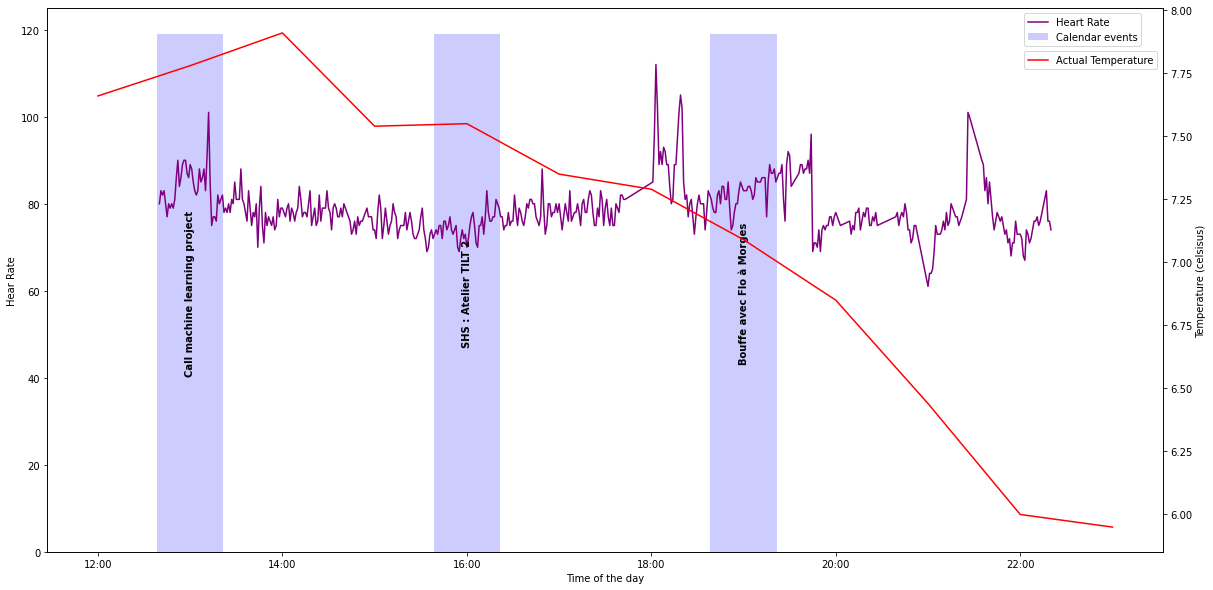

In [18]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(20, 10))

# Plot Hear rate data
hr = ax.plot(df_heart_rate_json['start_time'],
        df_heart_rate_json['heart_rate'],
        color='purple', label='Heart Rate')

# Set bar plots style for events
cal = ax.bar(df_filtered_dates['start_time'],
        df_filtered_dates['plot_dummies'],
        color='blue', width=0.03, alpha=0.2, label='Calendar events')
ax.bar_label(cal, labels=df_filtered_dates['Title'], label_type='center', rotation=90, weight='bold')

# Format dates as hours:minutes
xformatter = mdates.DateFormatter('%H:%M')
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)


# Set title and labels for axes
ax.set(xlabel="Time of the day",
       ylabel="Hear Rate")

# Create format for plotting temperature
ax2=ax.twinx()

#Remove the night for purposes of plotting
df_weather_loc = df_weather.copy()
df_weather_loc = df_weather_loc.drop(range(12))

ax2.plot(df_weather_loc['time'], df_weather_loc['actual_temp'], color='red', label='Actual Temperature')
ax2.set_ylabel("Temperature (celsisus)")

# Ading legends
ax.legend(bbox_to_anchor=(0.985, 1))
ax2.legend(bbox_to_anchor=(0.999, 0.93))


# Display plot
plt.show()